# Topic modeling

### Load data

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
CLEAN_SUBTITLES = '../clean_subtitles/Disney/Animation'

subtitles = np.ndarray(shape=(0,3))

for r,d,files in os.walk(CLEAN_SUBTITLES):
    for f in files:
        with open(os.path.join(r,f), 'r', encoding='utf-8', errors='ignore') as r_fh:
            f_tokens = f.split('.')
            subtitles = np.append(subtitles, [[f_tokens[0], r[-4:], r_fh.read()]], axis=0)
            
documents = subtitles[:,2]

### Utils

In [3]:
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english') + ['shh', 'hoo', 'boo', 'uhoh', 'aah', 'heh', 'huh', 'ooh']

import spacy
nlp = spacy.load('en')

# split too long document (char_len > 1'000'000'000)
def lemmatization_single_doc(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    text_split = []
    if len(text) > 1000000:
        split_pos = text.find('.', 900000)
        text_split.append(text[:split_pos+1])
        text_split.append(text[split_pos+1:])
    else:
        text_split.append(text)
        
    text_out = []
    for t in text_split:
        doc = nlp(t) 
        partial_tokens = [
            token.text if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags
        ]
        text_out = text_out + partial_tokens 
        
    return " ".join(text_out)  


def lemmatization(texts):
    texts_out = []
    for text in texts: 
        texts_out.append(lemmatization_single_doc(text, ['NOUN']))
    return texts_out


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f'Topic {topic_idx}: '
        message += ', '.join(
            [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        )
        print(message,'\n')
    print()
    return

### Lemmatization and Tokenization

In [4]:
lem_documents = lemmatization(documents.tolist())

### Features extraction

In [5]:
tf_vectorizer = CountVectorizer(
    stop_words=en_stopwords,
    max_df=0.50,
    min_df=5,
    #ngram_range=(1,2),
    token_pattern='[a-zA-Z0-9]{3,}',
    lowercase=True
)

tf = tf_vectorizer.fit_transform(lem_documents)

### LDA

In [6]:
n_components = 10

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=1000,
    learning_method = 'batch',
    n_jobs=-1,
    verbose=0
)

lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=1000,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [7]:
n_top_words = 20
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topic 0: princess, prince, magic, daddy, dear, king, hair, child, castle, birthday, queen, monster, spell, kingdom, daughter, forest, city, merry, sea, sister 

Topic 1: game, mom, kids, hero, money, car, ship, town, number, girls, brother, child, case, suit, buddy, hat, hours, deal, games, powers 

Topic 2: cat, dog, food, rat, chef, restaurant, frog, soup, cats, kitchen, dogs, evening, darling, diamond, garbage, recipe, penny, cook, pets, alley 

Topic 3: men, jungle, sea, village, treasure, hook, boat, island, captain, ship, fish, somethin, stories, ocean, star, song, nothin, sky, map, conscience 

Topic 4: pig, kingdom, sword, king, war, warrior, army, food, child, dress, death, dreams, ball, weapons, breakfast, land, master, throne, men, strength 

Topic 5: future, science, bugs, fish, food, bird, dog, machine, dad, sky, team, monsters, mask, school, lad, project, cover, line, rock, circus 

Topic 6: bear, tree, king, tail, elephant, rabbit, bees, rain, expedition, bounce, stick, 

### Projecting documents into topics

In [8]:
topics = lda.transform(tf)

tdf = pd.DataFrame(topics)
tdf.insert(loc=0, column='decade', value=subtitles[:,1])
tdf.insert(loc=0, column='movie', value=subtitles[:,0])
print('shape:', tdf.shape)
tdf.head(10)

shape: (88, 12)


,movie,decade,0,1,2,3,4,5,6,7,8,9
0,Hercules,1990,0.197003,0.664453,0.000194,0.066738,0.000194,0.070641,0.000194,0.000194,0.000194,0.000194
1,Toy Story,1990,0.000184,0.246259,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.752270
2,A Goofy Movie,1990,0.000268,0.000268,0.000268,0.189511,0.000268,0.000268,0.000268,0.000268,0.000268,0.808344
3,A Bug's Life,1990,0.000179,0.000179,0.000179,0.000179,0.000179,0.998387,0.000179,0.000179,0.000179,0.000179
4,The Nightmare Before Christmas,1990,0.185290,0.189244,0.032968,0.295605,0.000267,0.097175,0.000267,0.000267,0.000267,0.198650
5,The Lion King,1990,0.000246,0.000246,0.000246,0.000246,0.207662,0.000246,0.790367,0.000246,0.000246,0.000246
6,The Rescuers Down Under,1990,0.000329,0.000329,0.000329,0.000329,0.000329,0.000329,0.997039,0.000329,0.000329,0.000329
7,Aladdin,1990,0.998262,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193
8,Pocahontas,1990,0.000211,0.000211,0.000211,0.284354,0.000211,0.000211,0.000211,0.713954,0.000211,0.000211
9,Beauty and the Beast,1990,0.570711,0.087785,0.000225,0.000225,0.000225,0.000225,0.000225,0.339927,0.000225,0.000225


### Group by 'decade' then aggregate by 'mean'

In [9]:
mean_df = tdf.loc[:, tdf.columns != 'movie'].groupby(by=['decade']).agg('mean')
mean_df

,0,1,2,3,4,5,6,7,8,9
decade,,,,,,,,,,
1930,0.297999,0.000356,0.000356,0.699153,0.000356,0.000356,0.000356,0.000356,0.000356,0.000356
1940,0.000386,0.000386,0.000386,0.183319,0.000386,0.000386,0.249546,0.498029,0.000386,0.066792
1950,0.363295,0.031415,0.059553,0.266161,0.199649,0.000284,0.078793,0.000284,0.000284,0.000284
1960,0.160017,0.135502,0.030524,0.173905,0.025281,0.194253,0.090622,0.155741,0.000247,0.033909
1970,0.172559,0.087121,0.362793,0.069910,0.000286,0.000286,0.249720,0.000286,0.000286,0.056754
1980,0.326237,0.110269,0.033163,0.232404,0.199636,0.000343,0.000343,0.000343,0.007418,0.089845
1990,0.193432,0.132996,0.004569,0.121908,0.026456,0.099157,0.126053,0.120860,0.000241,0.174327
2000,0.100216,0.246644,0.068522,0.121367,0.000579,0.058962,0.084516,0.094993,0.076740,0.147462
2010,0.155177,0.258239,0.001498,0.043680,0.046348,0.070641,0.031764,0.087790,0.169624,0.135239


## ALL MOVIES OF A DECADE IN ONLY ONE DOCUMENT

### Load data

In [10]:
decade_subs = np.ndarray(shape=(0,2))

for r,d,files in os.walk(CLEAN_SUBTITLES):
    if (len(files) < 1):
        continue
        
    subs = str()
    for f in files:
        with open(os.path.join(r,f), 'r', encoding='utf-8', errors='ignore') as r_fh:
            subs = subs + ' ' + r_fh.read()
            
    decade_subs = np.append(decade_subs, [[r[-4:], subs]], axis=0)
            
decade_documents = decade_subs[:,1]

### Lemmatization and Tokenization

In [11]:
decade_lem_documents = lemmatization(decade_documents.tolist())

### Features extraction

In [12]:
decade_tf = tf_vectorizer.transform(decade_lem_documents)

### LDA - Projecting decade documents into topics

In [13]:
decade_topics = lda.transform(decade_tf)

### Decades - Topics dataframe

In [14]:
decade_tdf = pd.DataFrame(decade_topics)
decade_tdf.insert(loc=0, column='decade', value=decade_subs[:,0])
print('shape:', tdf.shape)
decade_tdf.set_index('decade',inplace=True)
decade_tdf.sort_index(inplace=True)
decade_tdf.head(10)

shape: (88, 12)


,0,1,2,3,4,5,6,7,8,9
decade,,,,,,,,,,
1930,0.297999,0.000356,0.000356,0.699153,0.000356,0.000356,0.000356,0.000356,0.000356,0.000356
1940,0.046139,0.018144,0.000086,0.225174,0.000086,0.000086,0.227822,0.384642,0.020477,0.077345
1950,0.422698,0.030197,0.056838,0.270895,0.130172,0.000055,0.088980,0.000055,0.000055,0.000055
1960,0.180065,0.134479,0.018905,0.198999,0.017604,0.213637,0.099154,0.121448,0.000081,0.015628
1970,0.184151,0.103029,0.246550,0.084477,0.000069,0.000069,0.324100,0.000069,0.000069,0.057416
1980,0.409006,0.131499,0.056092,0.174425,0.140944,0.000064,0.000064,0.000064,0.011139,0.076702
1990,0.226433,0.177745,0.003357,0.114770,0.021655,0.082137,0.054749,0.107484,0.000015,0.211655
2000,0.099030,0.266422,0.076996,0.110100,0.000009,0.083887,0.071576,0.051373,0.082702,0.157907
2010,0.131291,0.323030,0.000008,0.025774,0.013621,0.046961,0.015803,0.053556,0.243852,0.146104


## RESULT BY DECADE
#### Two aggregation methods: by "all in one decade document" and by mean

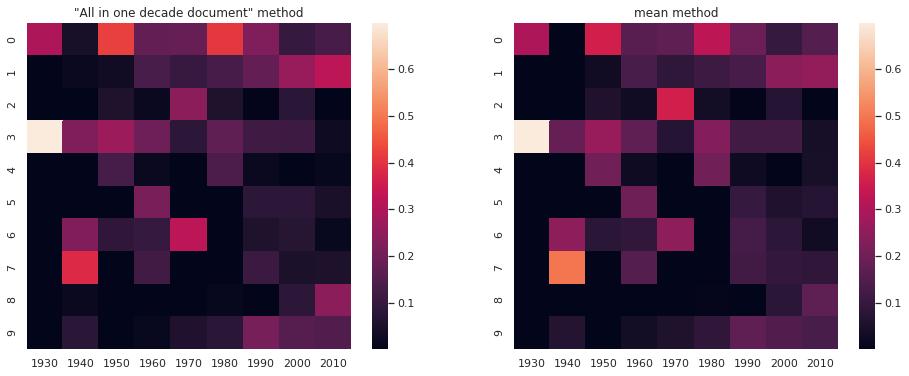

In [15]:
plt.figure(figsize=(16,6))

plt.subplot(121)
ax1 = sns.heatmap(decade_tdf.values.T, xticklabels=decade_tdf.index.values)
ax1.set_title('\"All in one decade document\" method')

plt.subplot(122)
ax2 = sns.heatmap(mean_df.values.T, xticklabels=mean_df.index.values)
ax2.set_title('mean method')

plt.show()